#  Evaluations - Inject SControl 170

In [14]:
import pandas as pd
import numpy as np
import  matplotlib.pyplot as plt
import re
from omnetpp.scave import results, chart, utils
%matplotlib inline  

In [15]:
config_vec = "InjectSControl_170-*.vec"
config_sca = "InjectSControl_170-*.sca"

pre = "InjectSControl_170_" # prefix for saved files

read_data_from_results = True

## Max Latencies

### Function definitions

In [16]:
def get_device(module):
    return module.split(".")[1]

def get_streamId(module, df):
    # assumning that streamIds are deterministic
    attrname = "*." + module.split(".")[1] + "." + module.split(".")[2] + ".display-name"
    attrval = df.loc[df['attrname'] == attrname,'attrvalue']
    try:
        return attrval.to_list()[0].split(" ")[0]
    except:
        return " "

def streamencodings(df):
    df_notna = df[df['attrname'].notna()]
    all_encodings = df_notna.loc[df_notna['attrname'].str.contains(".bridging.streamCoder.encoder.mapping")]
    # build a single json file based on streamname as key
    encodings = dict()
    for idx, row in all_encodings.iterrows():
        dev = row['attrname']
        encoding_str = row['attrvalue']
        encoding = re.findall(r'\{([^}]*)\}', encoding_str)
        for item in encoding:
            enc = item.split(",")  
            for e in enc:
                if "stream" in e:
                    stream = re.findall('"([^"]*)"', e)[0]
                elif "pcp" in e:
                    pcp = re.findall(r'\d+', e)[0]
                elif "vlan" in e:
                    vlan = re.findall(r'\d+', e)[0]
            # add infos to stream encoding
            if stream in encodings.keys():
                if pcp not in encodings[stream]['pcp']:
                    encodings[stream]['pcp'].append(pcp)
                if vlan not in encodings[stream]['vlan']:
                    encodings[stream]['vlan'].append(vlan)
                if dev not in encodings[stream]['dev']:
                    encodings[stream]['dev'].append(dev)
            else:
                encodings[stream] = {'pcp' : [pcp],
                                    'vlan' : [vlan],
                                    'dev' : [dev]}
    return encodings
        
def set_streamId(name): # streamnames are only sometimes deterministic, these are the special cases
    if "_" in name: # CAN
        return "SControl"
    if name == "SReset": # a single stream that is not formatted the same
        return "SControl"
    if name == " ": # Tcp-Stream
        return "SEtsiCamOut"
    
    return name

def get_pcp(streamname, device , df):
    if "zonalController" in device:
        attrname = "*.zonalController*.bridging.streamCoder.decoder.mapping"
    else:
        attrname = "*." + device + ".bridging.streamCoder.decoder.mapping"
    
    try:
        decoding_str = df.loc[df['attrname']==attrname, 'attrvalue'].to_list()[0]
        decoding = re.findall(r'\{([^}]*)\}', decoding_str)
        # get pcp for the stream from the table
        for item in decoding:
            if (streamname + "\"") in item:
                return item.split(",")[1][-1:]
    except:
        return " "

def get_pcp_from_encodings(streamname, encodings):
    try:
        return encodings[streamname]['pcp'][0]
    except:
        return " "
        

def max_delay(vals):
    try:
        return vals.max()
    except Exception as e:
        print(e)
        return "ERROR"


def extract_e2edelay(df):
    res = df[['runID','module', 'vectime', 'vecvalue']].dropna()
    res['device'] = res.apply(lambda row: get_device(row['module']), axis=1)
    res['streamname'] = res.apply(lambda row: get_streamId(row['module'], df), axis=1)
    res['streamname-Control'] = res.apply(lambda row: set_streamId(row['streamname']), axis=1)
    encodings  = streamencodings(df)
    res['pcp'] = res.apply(lambda row: get_pcp_from_encodings(row['streamname-Control'], encodings), axis=1)
    res['max e2e delay'] = res.apply(lambda row: max_delay(row['vecvalue']), axis=1)
    
    return res

### Evaluate latencies and jitter

In [17]:
# read results
if read_data_from_results:
    res = results.read_result_files(filenames = config_vec,
                                filter_expression = "name =~ meanBitLifeTimePerPacket:vector")
    latencies = extract_e2edelay(res)
    latencies.to_pickle(pre+"latencies_data")
else:
    latencies = pd.read_pickle(pre+"latencies_data")

In [18]:
latency_jitter_by_priority = []
for prio, group in latencies.groupby('pcp'):
    sorted = group.sort_values('max e2e delay', ascending = False)
    
    max_latency = group['max e2e delay'].max()
    min_latency = group['max e2e delay'].min()
    jitter = max_latency - min_latency

    max_stream = group.loc[group['max e2e delay'] == max_latency, 'module'].to_list()

    latency_jitter_by_priority.append({"pcp": prio,
                                       "max latency [s]": max_latency,
                                       "min latency [s]": min_latency,
                                       "jitter [s]": jitter,
                                       "stream with max latency": max_stream
                                      })

df_latency_prio = pd.DataFrame(latency_jitter_by_priority)

df_latency_prio.to_csv(pre+"latency_by_prio.csv", index=False)
df_latency_prio


    
    

,pcp,max latency [s],min latency [s],jitter [s],stream with max latency
0,2,0.000224,0.000034,0.000191,[Car.connectivityGateway.app[0].connection[0]....
1,4,0.000259,0.000005,0.000254,[Car.zonalControllerRearRight.app[91].sink]
2,5,0.000157,0.000062,0.000095,[Car.adas.app[2].sink]
3,6,0.000099,0.000033,0.000066,[Car.zonalControllerFrontLeft.app[5].sink]


### Latencies Prio 6, per stream

In [19]:
l_p6  = latencies.loc[latencies['pcp'] == "6"].copy()

In [20]:
l_p6['min e2e delay'] = l_p6.apply(lambda row: row['vecvalue'].min(), axis=1)
l_p6['jitter'] = l_p6.apply(lambda row: row['max e2e delay'] - row['min e2e delay'], axis=1)

In [21]:
l_p6_streams = l_p6[['module','device', 'streamname', 'max e2e delay', 'min e2e delay', 'jitter']].sort_values('max e2e delay', ascending=False)
l_p6_streams.rename(columns= {'max e2e delay': 'max e2e delay [s]', 'min e2e delay': 'min e2e delay [s]', 'jitter': 'jitter [s]'}, inplace=True)
l_p6_streams.to_csv(pre+"latencies_prio6.csv")

In [22]:
l_p6_streams

,module,device,streamname,max e2e delay [s],min e2e delay [s],jitter [s]
3562,Car.zonalControllerFrontLeft.app[5].sink,zonalControllerFrontLeft,SAutoSteer,0.000099,0.000097,0.000003
3569,Car.zonalControllerRearRight.app[2].sink,zonalControllerRearRight,SManualSteer,0.000099,0.000097,0.000003
3548,Car.zonalControllerFrontLeft.app[4].sink,zonalControllerFrontLeft,SAutoBrake,0.000097,0.000095,0.000003
3555,Car.zonalControllerRearRight.app[1].sink,zonalControllerRearRight,SManualBrake,0.000097,0.000095,0.000003
3534,Car.zonalControllerFrontLeft.app[3].sink,zonalControllerFrontLeft,SAutoThrottle,0.000096,0.000093,0.000003
3541,Car.zonalControllerRearRight.app[0].sink,zonalControllerRearRight,SManualThrottle,0.000095,0.000093,0.000003
3527,Car.zonalControllerRearLeft.app[5].sink,zonalControllerRearLeft,SAutoSteer,0.000069,0.000066,0.000003
3506,Car.zonalControllerFrontRight.app[2].sink,zonalControllerFrontRight,SManualSteer,0.000069,0.000066,0.000003
3520,Car.zonalControllerFrontRight.app[5].sink,zonalControllerFrontRight,SAutoSteer,0.000069,0.000066,0.000003
3513,Car.zonalControllerRearLeft.app[2].sink,zonalControllerRearLeft,SManualSteer,0.000068,0.000066,0.000002


### Latencies Prio 5, per stream

In [23]:
l_p5  = latencies.loc[latencies['pcp'] == "5"].copy()

l_p5['min e2e delay'] = l_p5.apply(lambda row: row['vecvalue'].min(), axis=1)
l_p5['jitter'] = l_p5.apply(lambda row: row['max e2e delay'] - row['min e2e delay'], axis=1)

l_p5_streams = l_p5[['module','device', 'streamname', 'max e2e delay', 'min e2e delay', 'jitter']].sort_values('max e2e delay', ascending=False)
l_p5_streams.rename(columns= {'max e2e delay': 'max e2e delay [s]', 'min e2e delay': 'min e2e delay [s]', 'jitter': 'jitter [s]'}, inplace=True)
l_p5_streams.to_csv(pre+"latencies_prio5.csv")

l_p5_streams

,module,device,streamname,max e2e delay [s],min e2e delay [s],jitter [s]
3422,Car.adas.app[2].sink,adas,SLidarFrontLeft,0.000157,0.000077,0.000081
3415,Car.adas.app[4].sink,adas,SLidarRearLeft,0.000127,0.000047,0.000080
3408,Car.adas.app[3].sink,adas,SLidarFrontRight,0.000119,0.000045,0.000074
3394,Car.adas.app[1].sink,adas,SVideoRear,0.000116,0.000034,0.000082
3387,Car.adas.app[0].sink,adas,SVideoFront,0.000115,0.000034,0.000081
3401,Car.adas.app[5].sink,adas,SLidarRearRight,0.000062,0.000029,0.000032


### Latencies Prio 4, per stream

In [24]:
l_p4  = latencies.loc[latencies['pcp'] == "4"].copy()

l_p4['min e2e delay'] = l_p4.apply(lambda row: row['vecvalue'].min(), axis=1)
l_p4['jitter'] = l_p4.apply(lambda row: row['max e2e delay'] - row['min e2e delay'], axis=1)

l_p4_streams = l_p4[['module','device', 'streamname', 'max e2e delay', 'min e2e delay', 'jitter']].sort_values('max e2e delay', ascending=False)
l_p4_streams.rename(columns= {'max e2e delay': 'max e2e delay [s]', 'min e2e delay': 'min e2e delay [s]', 'jitter': 'jitter [s]'}, inplace=True)
l_p4_streams.to_csv(pre+"latencies_prio4.csv")

l_p4_streams

,module,device,streamname,max e2e delay [s],min e2e delay [s],jitter [s]
3681,Car.zonalControllerRearRight.app[91].sink,zonalControllerRearRight,SAirbag_03,0.000259,0.000006,0.000253
3674,Car.zonalControllerRearRight.app[89].sink,zonalControllerRearRight,SAirbag_01,0.000258,0.000005,0.000253
3912,Car.zonalControllerRearRight.app[112].sink,zonalControllerRearRight,SGetriebe_06,0.000258,0.000010,0.000247
3905,Car.zonalControllerRearRight.app[87].sink,zonalControllerRearRight,SACC_10,0.000257,0.000009,0.000247
3898,Car.zonalControllerRearRight.app[86].sink,zonalControllerRearRight,SACC_07,0.000256,0.000008,0.000248
...,...,...,...,...,...,...
5206,Car.zonalControllerRearRight.app[111].sink,zonalControllerRearRight,SGateway_79,0.000015,0.000002,0.000013
5010,Car.zonalControllerFrontLeft.app[137].sink,zonalControllerFrontLeft,SNavPos_01,0.000012,0.000003,0.000010
4989,Car.zonalControllerFrontLeft.app[136].sink,zonalControllerFrontLeft,SNavData_02,0.000011,0.000002,0.000009
4975,Car.zonalControllerFrontLeft.app[135].sink,zonalControllerFrontLeft,SNavData_01,0.000007,0.000001,0.000006


### latencies per prio

In [59]:
latencies_extend = latencies.copy()
latencies_extend['min e2e delay'] = latencies_extend.apply(lambda row: row['vecvalue'].min(), axis=1)
latencies_extend['jitter'] = latencies_extend.apply(lambda row: row['max e2e delay'] - row['min e2e delay'], axis=1)

lat = []
for prio, group in latencies_extend.groupby('pcp'):
    max_delay = group['max e2e delay'].max()
    max_d_stream = group.loc[group['max e2e delay'] == max_delay, 'module'].to_list()
    max_jitter = group['jitter'].max()
    max_j_stream = group.loc[group['jitter'] == max_jitter, 'module'].to_list()

    lat.append({"pcp": prio,
               "max latency [s]": max_delay,
               "streams with max latency": max_d_stream,
               "max jitter [s]": max_jitter,
               "streams with max jitter": max_j_stream})

latencies_pcp = pd.DataFrame(lat)

latencies_pcp.to_csv(pre+"latency_jitter_pcp.csv", index=False)

latencies_pcp

,pcp,max latency [s],streams with max latency,max jitter [s],streams with max jitter
0,2,0.000224,[Car.connectivityGateway.app[0].connection[0]....,0.000221,[Car.connectivityGateway.app[0].connection[0]....
1,4,0.000259,[Car.zonalControllerRearRight.app[91].sink],0.000253,"[Car.zonalControllerRearRight.app[89].sink, Ca..."
2,5,0.000157,[Car.adas.app[2].sink],0.000082,[Car.adas.app[1].sink]
3,6,0.000099,[Car.zonalControllerFrontLeft.app[5].sink],0.000003,"[Car.zonalControllerRearLeft.app[3].sink, Car...."


### Evaluate if apps receive data

In [25]:
def get_appno(module):
    num = re.findall(r'\[.*?\]', module)[0]
    nums = re.findall(r'\d+', num)
    if ".." in num:
        r_nums = []
        for i in range (int(nums[0]), int(nums[1])+1):
            r_nums.append(i)
        return r_nums
    else:
        return nums

In [26]:
# find all configured sinks
df_sinkapps = res.loc[res['attrvalue'].isin(["UdpSinkApp", "TcpClientApp", "TcpServerApp"]), ['attrname', 'attrvalue']]

configured_sinks = []
for idx, row in df_sinkapps.iterrows():
    if ".." in row['attrname']: # config for multiple apps
        nums = get_appno(row['attrname'])
        for n in nums:
            sink = get_device(row['attrname']) + ".app[" + str(n) + "]"
            configured_sinks.append(sink)
    else:
        sink = get_device(row['attrname']) + ".app[" + re.findall(r'\d+', row['attrname'])[0] + "]"
        configured_sinks.append(sink)


NameError: name 'res' is not defined

In [ ]:
# find all sinks that received at least one packet that is counted towards latency-results
sinks_receiving_data = latencies['module'].to_list()

# and bring them in same format as configured_strings
sinks_receiving_data_formatted = []
for sink in sinks_receiving_data:
    formatted = sink.split(".")[1] + "." + sink.split(".")[2]
    sinks_receiving_data_formatted.append(formatted)


In [ ]:
# compare the lists

# only configured
diff_conf = []
for s in configured_sinks:
    if s not in sinks_receiving_data_formatted:
        diff_conf.append(s)

diff_conf

# all of these apps do have a 'dropped data rate', if you check them by hand, is this wanted?

In [ ]:
# only in results
diff_res = []
for s in sinks_receiving_data_formatted:
    if s not in configured_sinks:
        diff_res.append(s)

diff_res

## Queueing

### Function definitions

In [27]:
### Function definitions
def get_devicePort(module):
    split = module.split(".")
    return split[1] + "." + split[2]

def get_queueNo(module):
    split = module.split(".")
    if len(split) < 6:
        return "all"
    else:
        return split[5]


def extract_maxq(df):
    res = df[['runID', 'module', 'value']].dropna()
    res.sort_values(by='value', ascending=False, inplace=True)
#res_maxq['device'] = res_maxq.apply(lambda row: get_device(row['module']), axis=1)
    res['device+port'] = res.apply(lambda row: get_devicePort(row['module']), axis=1)
    res['queue'] = res.apply(lambda row: get_queueNo(row['module']), axis=1)
    res = res[['runID','device+port', 'queue', 'value']]
    return res

### Max queuelengths

In [28]:
# read results
if read_data_from_results:
    res_q = results.read_result_files(filenames = config_sca,
                                filter_expression = "module =~ *.eth[*].macLayer.queue* AND name =~ queueLength:max")
    max_q = extract_maxq(res_q)
    max_q.to_pickle(pre+"queues_data")
else:
    max_q = pd.read_pickle(pre+"queues_data")

In [29]:
# queues by priority

qs = []
for q, group in max_q.groupby('queue'):
    max = group['value'].max()
    port = group.loc[group['value'] == max]
    ports = port['device+port'].to_list()
    if q == "all":
       qs.append({"prio": "all",
                "max": max,
                 "port": ports}) 
    else:
        prio = re.findall(r'\d+', q)[0]
        qs.append({"prio": prio,
                   "max": max,
                   "port": ports})

df_qs = pd.DataFrame(qs)

df_qs
    

,prio,max,port
0,all,185.0,[zonalControllerRearRight.eth[0]]
1,0,131.0,[zonalControllerFrontLeft.eth[0]]
2,2,1.0,"[switchRearLeft.eth[1], adas.eth[0], connectiv..."
3,4,79.0,[zonalControllerRearRight.eth[0]]
4,5,7.0,[switchRearRight.eth[2]]
5,6,6.0,"[switchRearLeft.eth[4], switchRearRight.eth[3]..."
6,7,4.0,[switchRearRight.eth[2]]


### Queues over time

In [30]:
def extract_data_qlen(df):
    res = df[['runID','module', 'vectime', 'vecvalue']].dropna()
    res['device+port'] = res.apply(lambda row: get_devicePort(row['module']), axis=1)
    res['queue'] = res.apply(lambda row: get_queueNo(row['module']), axis=1)
    res['max length'] = res.apply(lambda row: row['vecvalue'].max(), axis=1)
    return res

def set_curmax(vec):
    max = 0
    res = []
    for v in vec:
        if v > max:
            max = v
            res.append(v)
        else:
            res.append(max)
    return res

def get_maxtime(time, vec, max):
    m_idx = [i for i, v in enumerate(vec) if v == max]
    return time[m_idx]

In [31]:
# read results
if read_data_from_results:
    res_qv = results.read_result_files(filenames = config_vec,
                                filter_expression = "module =~ *macLayer.queue* AND name =~ queueLength:vector")
    qvs = extract_data_qlen(res_qv)
    qvs.to_pickle(pre+"queues_vec_data")
else:
    qvs = pd.read_pickle(pre+"queues_vec_data")

#### classify behaviour of streams (somehow)...

In [32]:
qvs['current max'] = qvs.apply(lambda row: set_curmax(row['vecvalue']), axis=1)
qvs['times of max'] = qvs.apply(lambda row: get_maxtime(row['vectime'], row['vecvalue'], row['max length']), axis=1)
qvs['latest time of max'] = qvs.apply(lambda row: row['times of max'].max(), axis=1)
qvs['number of max'] = qvs.apply(lambda row: len(row['times of max']), axis=1)

In [33]:
# Streams that reach their max in the last second (but max reach it before then too)
qvs_lastsec = qvs[['device+port', 'queue', 'max length']].loc[qvs['latest time of max'] > 9.0].sort_values('max length', ascending=False)
qvs_lastsec.loc[qvs_lastsec['queue'] != "all"]

,device+port,queue,max length
3908,switchFrontRight.eth[1],queue[4],73.0
3735,zonalControllerFrontLeft.eth[0],queue[4],43.0
3940,switchFrontLeft.eth[0],queue[4],39.0
3932,switchRearRight.eth[1],queue[4],15.0
3986,switchRearLeft.eth[4],queue[4],13.0
4033,switchFrontLeft.eth[5],queue[4],8.0
3924,switchRearRight.eth[0],queue[4],8.0
4303,switchRearRight.eth[2],queue[5],7.0
4319,switchFrontRight.eth[4],queue[6],6.0
4335,switchRearLeft.eth[4],queue[6],6.0


In [34]:
# streams that reach max less than 5 times during runtime
qvs_fewmax =qvs[['device+port', 'queue', 'max length', 'number of max', 'times of max']].loc[qvs['number of max'] < 5].sort_values('max length', ascending=False)
qvs_fewmax.loc[qvs_fewmax['queue'] != "all"]

,device+port,queue,max length,number of max,times of max
3687,zonalControllerFrontLeft.eth[0],queue[0],131.0,1,[0.0]
3695,zonalControllerFrontRight.eth[0],queue[0],120.0,1,[0.0]
3711,zonalControllerRearRight.eth[0],queue[0],105.0,1,[0.0]
3759,zonalControllerRearRight.eth[0],queue[4],79.0,1,[0.0]
3743,zonalControllerFrontRight.eth[0],queue[4],62.0,1,[0.0]
...,...,...,...,...,...
4431,connectivityGateway.eth[0],queue[2],1.0,1,[0.000224113461]
4025,switchRearRight.eth[1],queue[2],1.0,3,"[3.5945e-06, 4.221992593423, 11.46891880818]"
3807,cameraRear.eth[0],queue[5],1.0,1,[0.0]
3799,cameraFront.eth[0],queue[5],1.0,1,[0.0]


In [35]:
prio6_qvs = qvs[['device+port', 'queue', 'max length', 'number of max', 'times of max']].loc[qvs['module'] == "Car.switchRearLeft.eth[4].macLayer.queue.queue[6]"]
for t in prio6_qvs['times of max']:
    print (t)

[3.38420000e-05 9.58420000e-05 1.03384200e-03 ... 1.19989787e+01
 1.19999167e+01 1.19999787e+01]


#### plot largest 5 queues per prio

In [36]:
plts_queues = []
for prio, g in qvs.groupby('queue'):
    plts_queues.append(g.sort_values('max length', ascending=False).head(5))

df_plt_q = pd.concat(plts_queues)

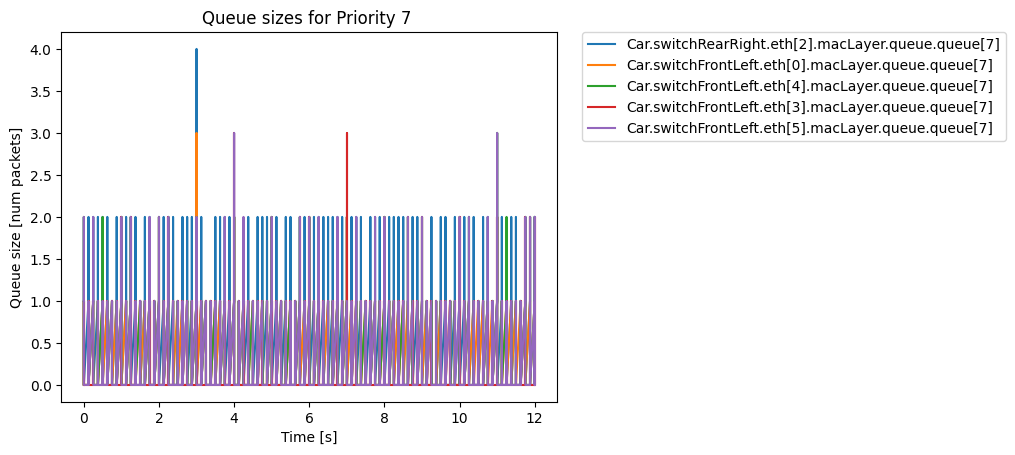

In [37]:
for idx, row in df_plt_q.loc[df_plt_q['queue'] == "queue[7]"].iterrows():
    plt.plot(row['vectime'], row['vecvalue'], label=row['module'])
    plt.title("Queue sizes for Priority 7 ")
    plt.xlabel("Time [s]")
    plt.ylabel("Queue size [num packets]")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

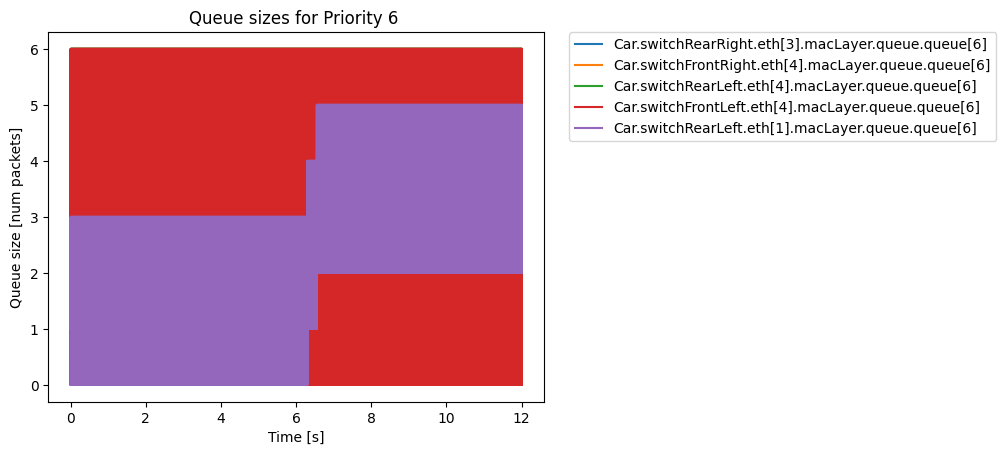

In [38]:
for idx, row in df_plt_q.loc[df_plt_q['queue'] == "queue[6]"].iterrows():
    plt.plot(row['vectime'], row['vecvalue'], label=row['module'])
    plt.title("Queue sizes for Priority 6 ")
    plt.xlabel("Time [s]")
    plt.ylabel("Queue size [num packets]")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

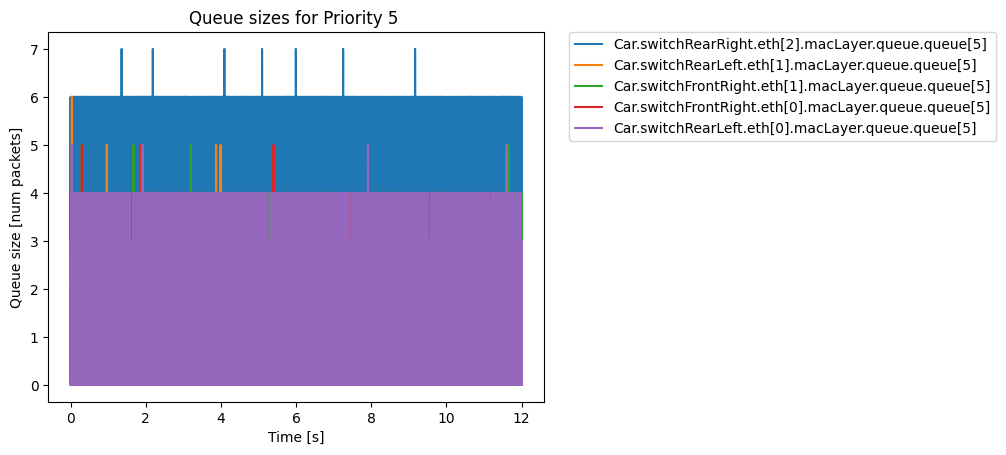

In [39]:
for idx, row in df_plt_q.loc[df_plt_q['queue'] == "queue[5]"].iterrows():
    plt.plot(row['vectime'], row['vecvalue'], label=row['module'])
    plt.title("Queue sizes for Priority 5 ")
    plt.xlabel("Time [s]")
    plt.ylabel("Queue size [num packets]")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

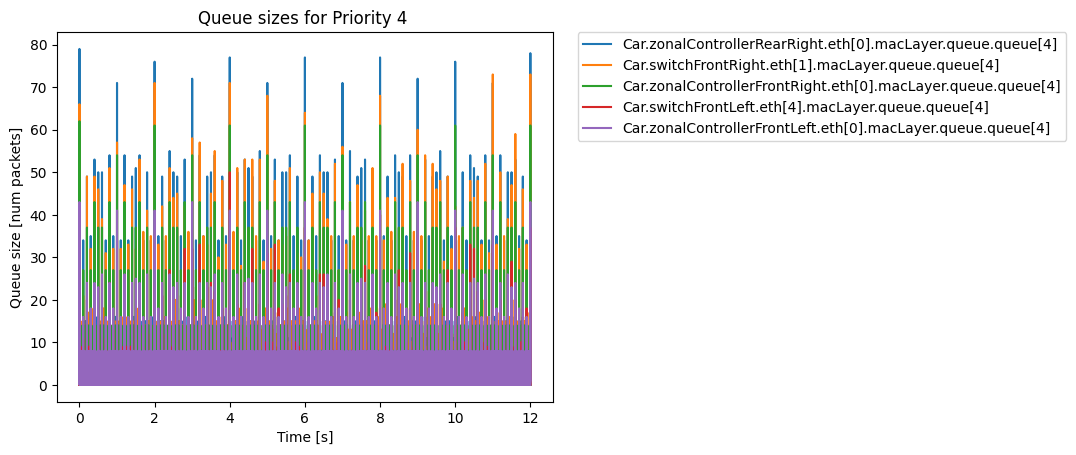

In [40]:
for idx, row in df_plt_q.loc[df_plt_q['queue'] == "queue[4]"].iterrows():
    plt.plot(row['vectime'], row['vecvalue'], label=row['module'])
    plt.title("Queue sizes for Priority 4 ")
    plt.xlabel("Time [s]")
    plt.ylabel("Queue size [num packets]")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

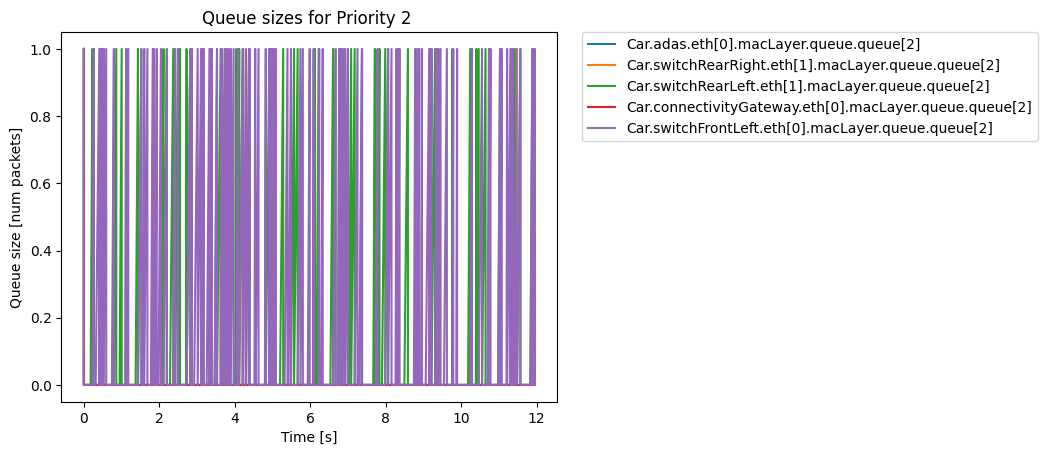

In [41]:
for idx, row in df_plt_q.loc[df_plt_q['queue'] == "queue[2]"].iterrows():
    plt.plot(row['vectime'], row['vecvalue'], label=row['module'])
    plt.title("Queue sizes for Priority 2 ")
    plt.xlabel("Time [s]")
    plt.ylabel("Queue size [num packets]")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

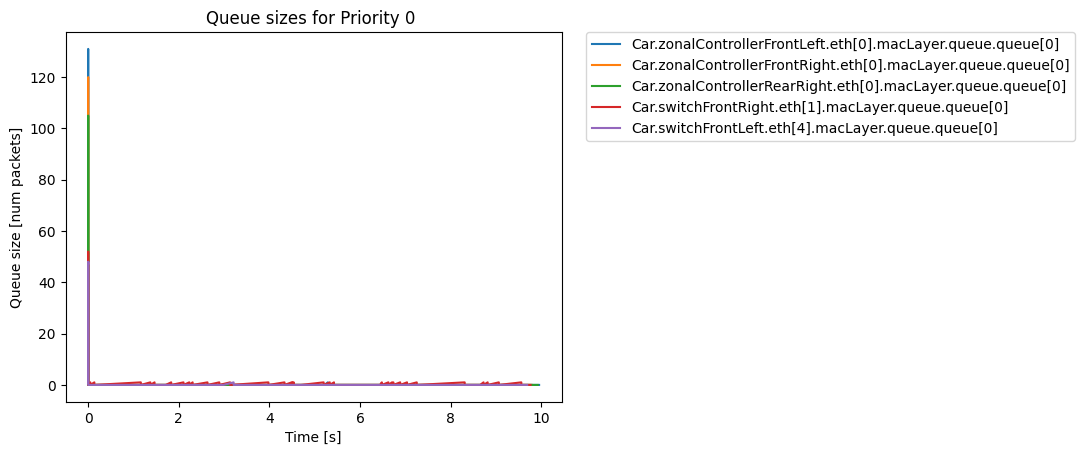

In [42]:
for idx, row in df_plt_q.loc[df_plt_q['queue'] == "queue[0]"].iterrows():
    plt.plot(row['vectime'], row['vecvalue'], label=row['module'])
    plt.title("Queue sizes for Priority 0 ")
    plt.xlabel("Time [s]")
    plt.ylabel("Queue size [num packets]")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

## Eval for scenario

In [43]:
# app angucken, anzahl gesendeter und empfangener pakete & bandbreite

In [44]:
res_p_source = results.read_result_files(filenames = config_vec,
                                 filter_expression = "module =~ *.zonalControllerRearLeft.app[6]* AND name =~ packetSent*")
res_p_sink1 = results.read_result_files(filenames = config_vec,
                                 filter_expression = "module =~ *.zonalControllerFrontRight.app[71]* AND name =~ packetReceived*")
res_p_sink2 = results.read_result_files(filenames = config_vec,
                                 filter_expression = "module =~ *.zonalControllerFrontLeft.app[49]* AND name =~ packetReceived*")


In [45]:
def extract_num_p(df):
    res = df[['runID','module', 'vectime', 'vecvalue']].dropna()
    res['device'] = res.apply(lambda row: get_device(row['module']), axis=1)
    return res

In [46]:
p_sent = extract_num_p(res_p_source)
p_sent['role'] = "source"
p_rec1 = extract_num_p(res_p_sink1)
p_rec1['role'] = "sink"
p_rec2 = extract_num_p(res_p_sink2)
p_rec2['role'] = "sink"

packs = pd.concat([p_sent, p_rec1, p_rec2])


In [47]:
def count_packs(vec):
    i = 1
    cnt = []
    for v in vec:
        cnt.append(i)
        i+= 1
    return cnt
        

In [48]:
packs_count = packs[['vectime', 'module', 'role']].copy()
packs_count['num packets'] = packs_count.apply(lambda row: count_packs(row['vectime']), axis=1)

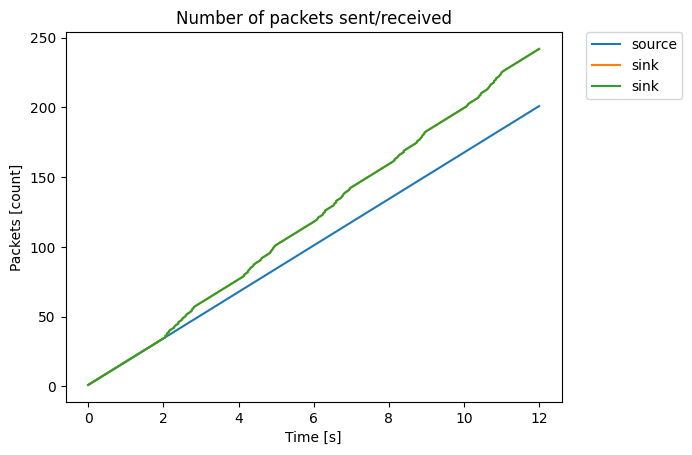

In [49]:
for idx, row in packs_count.iterrows():
    plt.plot(row['vectime'], row['num packets'], label=row['role'])
    plt.title("Number of packets sent/received")
    plt.xlabel("Time [s]")
    plt.ylabel("Packets [count]")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

## Num packets

In [55]:

def sourceorsink(attrname):
    if "localPort" in attrname:
        return "sink"
    elif "destPort" in attrname:
        return "source"
    elif "connectPort" in attrname: # this is TCP client
        return "source" 

def appports(df):
    r = df[['attrname', 'attrvalue']].dropna()
    info = r.loc[r['attrname'].str.contains("localPort|destPort|connectPort")].copy()
    #d = df.loc[df['attrname'].str.contains("destPort"), ['attrname', 'attrvalue']].copy()
    #c = df.loc[df['attrname'].str.contains("connectPort"), ['attrname', 'attrvalue']].copy()
    #info = pd.concat([l,d])
    info['deviceapp'] = info.apply(lambda row: get_devicePort(row['attrname']), axis=1)
    info['sourcesink'] = info.apply(lambda row: sourceorsink(row['attrname']), axis=1)
    info['port'] = info['attrvalue']
    
    return dict(zip(info.deviceapp, info.port))

def extract_numpacks(df):
    res = df[['runID', 'module', 'value']].dropna()
    res['device'] = res.apply(lambda row: get_device(row['module']), axis=1)
    res['device+app'] = res.apply(lambda row: get_devicePort(row['module']), axis=1)
    res['streamname'] = res.apply(lambda row: get_streamId(row['module'], df), axis=1)
    # get the application port (local and/or destination) to match apps later
    app_ports = appports(df)
    res['app-port'] = res.apply(lambda row: app_ports[row['device+app']], axis=1)
    return res

In [56]:
res_sources = results.read_result_files(filenames = config_sca,
                                 filter_expression = "module=~ *.io AND name =~ packetSent:count")
res_sinks = results.read_result_files(filenames = config_sca,
                                 filter_expression = "module =~ *.io AND name =~ packetReceived:count")

d_sources = extract_numpacks(res_sources)
d_sources['srcsink'] = "source"
d_sinks = extract_numpacks(res_sinks)
d_sinks['srcsink'] = "sink"

by_sink = []
for appport, group in d_sinks.groupby('app-port'):
    src = d_sources.loc[d_sources['app-port'] == appport]
    srcapp = src['device+app'].to_list()[0]
    srcpcks = src['value'].to_list()[0]
    for idx, row in group.iterrows():
        by_sink.append({ "app-port": appport,
                        "stream name": row['streamname'],
                        "source app": srcapp,
                        "destination app": row['device+app'],
                        "packets sent [count]": srcpcks,
                        "packets received [count]": row['value'],
                        "packets difference": srcpcks - row['value']})

packet_diff = pd.DataFrame(by_sink)

In [57]:
packet_diff.sort_values('packets difference', ascending = True)

,app-port,stream name,source app,destination app,packets sent [count],packets received [count],packets difference
247,5000,SACC_13,zonalControllerRearLeft.app[6],zonalControllerFrontLeft.app[49],201.0,242.0,-41.0
248,5000,SACC_13,zonalControllerRearLeft.app[6],zonalControllerFrontRight.app[71],201.0,242.0,-41.0
0,1000,SManualThrottle,zonalControllerFrontLeft.app[0],zonalControllerFrontRight.app[0],12001.0,12001.0,0.0
319,6024,SGateway_80,zonalControllerRearRight.app[30],zonalControllerFrontRight.app[101],13.0,13.0,0.0
318,6023,SGateway_72,zonalControllerRearRight.app[29],infotainment.app[28],121.0,121.0,0.0
...,...,...,...,...,...,...,...
102,3034,SSensorik_Dimmung_01,zonalControllerFrontLeft.app[40],zonalControllerRearRight.app[171],61.0,60.0,1.0
103,3035,SService_Key_01,zonalControllerFrontLeft.app[41],zonalControllerRearRight.app[172],121.0,120.0,1.0
35,3004,SAirbag_01,zonalControllerFrontLeft.app[10],zonalControllerRearRight.app[89],1201.0,1200.0,1.0
31,3002,SACC_07,zonalControllerFrontLeft.app[8],zonalControllerRearRight.app[86],601.0,600.0,1.0


In [58]:
packet_diff.to_csv(pre+"num_packets.csv", index=False)